In [1]:
# Importing necessary libraries
import os
import pandas as pd
import numpy as np
from PIL import Image
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Flatten, Dense
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import clear_output

In [2]:
# Setting the directory path
data_dir = Path("./Data/GRE_Train_368")

# Counting the number of images in PNG and JPG formats
image_count_png = len(list(data_dir.glob('*/*.png')))
image_count_jpg = len(list(data_dir.glob('*/*.jpg')))
image_count = image_count_png + image_count_jpg
print("Total Image Count:",image_count)


Total Image Count: 373


In [3]:
# Gathering image paths for different classes
bleed = list(data_dir.glob('bleed/*'))
bleed_calci = list(data_dir.glob('bleed_calci/*'))
calci = list(data_dir.glob('calci/*'))

In [4]:
# Setting batch size and image dimensions
batch_size = 4
img_height = 256
img_width = 256

In [5]:
# Creating training and validation datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 373 files belonging to 3 classes.
Using 336 files for training.
Found 373 files belonging to 3 classes.
Using 74 files for validation.


In [6]:
# Getting class names
class_names = train_ds.class_names
print("Class Names",class_names)

Class Names ['bleed', 'bleed_calci', 'calci']


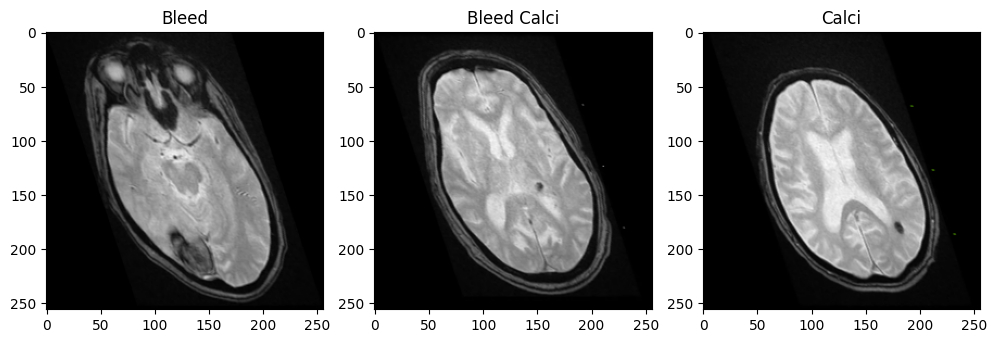

In [7]:
# Opening and displaying sample images from different classes
bleed_image = Image.open(str(bleed[23]))
bleed_calci_image = Image.open(str(bleed_calci[23]))
calci_image = Image.open(str(calci[23]))
plt.figure(figsize=(10, 4))
# First image
plt.subplot(1, 3, 1)
plt.imshow(bleed_image)
plt.title('Bleed')
# Second image
plt.subplot(1, 3, 2)
plt.imshow(bleed_calci_image)
plt.title('Bleed Calci')
# Third image
plt.subplot(1, 3, 3)
plt.imshow(calci_image)
plt.title('Calci')
# Adjust layout
plt.tight_layout()
plt.show()

In [8]:
# Printing shape of image and label batches
for image_batch, labels_batch in train_ds:
  print("Image batch shape:",image_batch.shape)
  print("labels batch shape:",labels_batch.shape)
  break

Image batch shape: (4, 256, 256, 3)
labels batch shape: (4,)


In [9]:
# Setting up data augmentation and normalization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print("Minimum and maximum pixel size",np.min(first_image), np.max(first_image))

Minimum and maximum pixel size 0.0 0.9803922


In [10]:
# Defining number of classes and data augmentation techniques
num_classes = len(class_names)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [23]:
from tensorflow.keras import Sequential, layers

# Define the model
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Flatten(input_shape=(256, 256, 3)),
])

# Add 25 Dense layers with Dropout
for _ in range(40):
    model.add(layers.Dense(256*2, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

# Add the final output layer
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), 
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 flatten_2 (Flatten)         (None, 196608)            0         
                                                                 
 dense_92 (Dense)            (None, 512)               100663808 
                                                                 
 batch_normalization_90 (Bat  (None, 512)              2048      
 chNormalization)                                                
                                                                 
 dropout_90 (Dropout)        (None, 512)               0         
                                                      

c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping],
)

Epoch 1/100


84/84 [==============================] - 13s 64ms/step - loss: 1.8041 - accuracy: 0.3393 - val_loss: 1.1545 - val_accuracy: 0.2838
Epoch 2/100
84/84 [==============================] - 4s 53ms/step - loss: 1.7755 - accuracy: 0.2976 - val_loss: 1.1307 - val_accuracy: 0.2838
Epoch 3/100
84/84 [==============================] - 4s 53ms/step - loss: 1.5950 - accuracy: 0.3512 - val_loss: 1.0710 - val_accuracy: 0.3243
Epoch 4/100
84/84 [==============================] - 4s 52ms/step - loss: 1.5333 - accuracy: 0.3720 - val_loss: 1.0285 - val_accuracy: 0.3919
Epoch 5/100
84/84 [==============================] - 4s 51ms/step - loss: 1.6201 - accuracy: 0.3899 - val_loss: 0.9167 - val_accuracy: 0.5676
Epoch 6/100
84/84 [==============================] - 4s 49ms/step - loss: 1.4818 - accuracy: 0.4256 - val_loss: 1.0027 - val_accuracy: 0.4730
Epoch 7/100
84/84 [==============================] - 4s 48ms/step - loss: 1.3965 - accuracy: 0.3929 - val_loss: 1.0338 - val_accuracy: 0.4865
Epoch 8/100
84/84

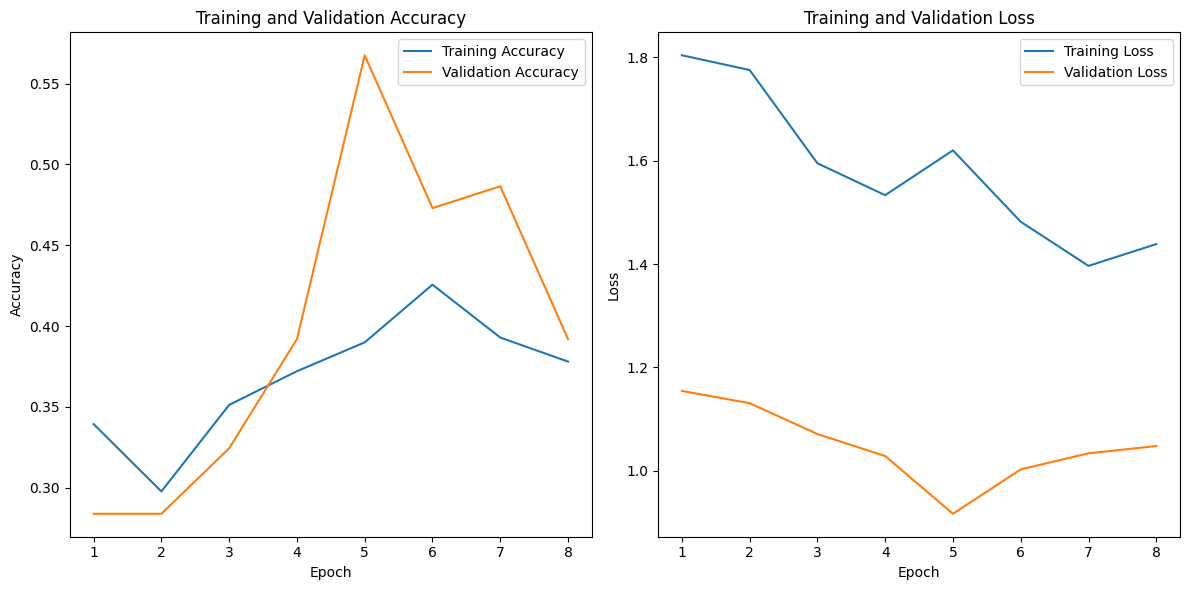

In [25]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot training history
plot_training_history(history)

In [26]:
# Define the folder paths for each class
folder_paths = [
    "./Data/GRE_Test/Bleed/",
    "./Data/GRE_Test/Bleed-calified/",
    "./Data/GRE_Test/Calification/"
]

# batch_size = 32
img_height = 256
img_width = 256

# Initialize lists to store ground truth and predicted labels
true_labels = []
predicted_labels = []

# Function to make predictions for all images in a folder
def predict_images_in_folder(folder_path, true_label):
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png') or file.endswith('.jpg')]
    for image_file in image_files:
        img = tf.keras.utils.load_img(image_file, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch
        predictions = model.predict(img_array)
        predicted_label = np.argmax(predictions[0])
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)

# Iterate over each folder and make predictions
for label, folder_path in enumerate(folder_paths):
    predict_images_in_folder(folder_path, label)

# Convert lists to numpy arrays for easier calculation
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

clear_output(wait=True)

1/1 [==============================] - 0s 18ms/step


In [27]:
# Calculate accuracy
accuracy = np.mean(true_labels == predicted_labels)
print("Accuracy:", accuracy)

# Calculate other related metrics
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

Accuracy: 0.3
Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.60      0.42        15
           1       1.00      0.17      0.29        18
           2       0.00      0.00      0.00         7

    accuracy                           0.30        40
   macro avg       0.44      0.26      0.23        40
weighted avg       0.57      0.30      0.29        40



In [28]:
# Create an empty list to store results
results = []

# Loop through each folder
for folder_path in folder_paths:
    # Get a list of all image files in the folder
    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.png') or file.endswith('.jpg')]

    # Loop through each image in the folder
    for image_file in image_files:
        # Suppress TensorFlow logging during prediction
        tf.get_logger().setLevel('ERROR')

        img = tf.keras.utils.load_img(image_file, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Get original label from folder name
        original_label = os.path.basename(os.path.dirname(image_file))

        # Append results to the list
        results.append({"Image File": os.path.basename(image_file),
                        "Original Label": original_label,
                        "Predicted Class": class_names[np.argmax(score)],
                        "Confidence (%)": 100 * np.max(score)})

# Create DataFrame from the list of results
results_df = pd.DataFrame(results)

# Clear output cell
clear_output(wait=True)

# Print DataFrame
results_df

,Image File,Original Label,Predicted Class,Confidence (%)
0,1.png,Bleed,bleed,38.472500
1,12.png,Bleed,calci,38.920486
2,13.png,Bleed,calci,39.000499
3,14.png,Bleed,bleed,38.849062
4,15.png,Bleed,bleed,39.371446
5,16.png,Bleed,bleed,45.684245
6,17.png,Bleed,bleed,42.157081
7,18.png,Bleed,calci,40.180564
8,2.png,Bleed,calci,39.156124
9,3.png,Bleed,bleed,39.834255
